In [187]:
!pip install xgboost


In [188]:
import xgboost as xgb


In [189]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import json
import gc
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import MultiLabelBinarizer, LabelEncoder
from xgboost import XGBClassifier

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [190]:

users = pd.read_csv('/Users/ramsharma/Desktop/Project/archive/users_data.csv')
tr = pd.read_csv('/Users/ramsharma/Desktop/Project/archive/transactions_data.csv')
cards = pd.read_csv('/Users/ramsharma/Desktop/Project/archive/cards_data.csv')

In [191]:
users.head()


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


In [192]:
users.isnull().sum()


id                   0
current_age          0
retirement_age       0
birth_year           0
birth_month          0
gender               0
address              0
latitude             0
longitude            0
per_capita_income    0
yearly_income        0
total_debt           0
credit_score         0
num_credit_cards     0
dtype: int64

In [193]:
users.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   object 
 10  yearly_income      2000 non-null   object 
 11  total_debt         2000 non-null   object 
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(2), int64(7), object(5)
memory usage: 218.9+ KB


In [194]:

#Converting 'per_capita_income', 'yearly_income', 'total_debt' to numeric data type.
var = ['per_capita_income', 'yearly_income', 'total_debt']
for i in var:
    users[i] = users[i].apply(lambda x: x.lstrip('$')).astype(float)

In [195]:
cards.head()


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No


In [196]:
cards.isnull().sum()


id                       0
client_id                0
card_brand               0
card_type                0
card_number              0
expires                  0
cvv                      0
has_chip                 0
num_cards_issued         0
credit_limit             0
acct_open_date           0
year_pin_last_changed    0
card_on_dark_web         0
dtype: int64

In [197]:
cards.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6146 entries, 0 to 6145
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   id                     6146 non-null   int64 
 1   client_id              6146 non-null   int64 
 2   card_brand             6146 non-null   object
 3   card_type              6146 non-null   object
 4   card_number            6146 non-null   int64 
 5   expires                6146 non-null   object
 6   cvv                    6146 non-null   int64 
 7   has_chip               6146 non-null   object
 8   num_cards_issued       6146 non-null   int64 
 9   credit_limit           6146 non-null   object
 10  acct_open_date         6146 non-null   object
 11  year_pin_last_changed  6146 non-null   int64 
 12  card_on_dark_web       6146 non-null   object
dtypes: int64(6), object(7)
memory usage: 624.3+ KB


In [198]:

#Converting 'credit_limit' to numeric data type. Converting 'has_chip' values to 1 & 0.
cards['credit_limit'] = cards['credit_limit'].apply(lambda x: x.lstrip('$')).astype(float)
cards['has_chip'] = cards['has_chip'].map({'YES':1, 'NO':0})

In [199]:
tr.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN


In [200]:
tr.isnull().sum()


id                       0
date                     0
client_id                0
card_id                  0
amount                   0
use_chip                 0
merchant_id              0
merchant_city            0
merchant_state     1563700
zip                1652706
mcc                      0
errors            13094522
dtype: int64

In [204]:
tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


In [202]:
tr

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
13305910,23761868,2019-10-31 23:56:00,1718,2379,$1.11,Chip Transaction,86438,West Covina,CA,91792.0,5499,NaN
13305911,23761869,2019-10-31 23:56:00,1766,2066,$12.80,Online Transaction,39261,ONLINE,NaN,NaN,5815,NaN
13305912,23761870,2019-10-31 23:57:00,199,1031,$40.44,Swipe Transaction,2925,Allen,TX,75002.0,4900,NaN
13305913,23761873,2019-10-31 23:58:00,1986,5443,$4.00,Chip Transaction,46284,Daly City,CA,94014.0,5411,NaN


In [30]:
# Null Values Found in 'errors', 'merchant_city', 'merchant_state'. Investigating and dealing with null values.

#Converting 'amount' to numeric datatype.

In [31]:
tr['errors'].unique()


array([nan, 'Technical Glitch', 'Bad Expiration', 'Bad Card Number',
       'Insufficient Balance', 'Bad PIN', 'Bad CVV', 'Bad Zipcode',
       'Insufficient Balance,Technical Glitch',
       'Bad PIN,Insufficient Balance', 'Bad PIN,Technical Glitch',
       'Bad Expiration,Technical Glitch',
       'Bad Card Number,Bad Expiration',
       'Bad Card Number,Insufficient Balance',
       'Bad Expiration,Insufficient Balance', 'Bad Card Number,Bad CVV',
       'Bad CVV,Technical Glitch', 'Bad Expiration,Bad CVV',
       'Bad CVV,Insufficient Balance', 'Bad Card Number,Technical Glitch',
       'Bad Zipcode,Insufficient Balance',
       'Bad Card Number,Bad Expiration,Insufficient Balance',
       'Bad Zipcode,Technical Glitch'], dtype=object)

In [32]:
# The null values in 'errors' represent a transactions which was successfully completed. Replacing null values with 'No Errors'.



In [33]:
tr['errors'] = tr['errors'].fillna('No Errors')

In [34]:

#Converting 'date' to date&time.
tr['date'] = pd.to_datetime(tr['date'])

In [35]:
#Converting 'amount' to numeric datatype.
tr['amount'] = tr['amount'].apply(lambda x: x.lstrip('$')).astype(float)

In [57]:
labels = pd.read_json('/Users/ramsharma/Desktop/Project/archive/train_fraud_labels.json')
labels.head()

,target
10649266,No
23410063,No
9316588,No
12478022,No
9558530,No


In [59]:
labels.reset_index(inplace=True)

In [184]:
labels

,id,target
0,10649266,No
1,23410063,No
2,9316588,No
3,12478022,No
4,9558530,No
...,...,...
8914958,14064699,No
8914959,7676538,No
8914960,15131030,No
8914961,17244732,No


In [60]:
labels.rename(columns={'index': 'id'}, inplace=True)

In [62]:
labels.columns

Index(['id', 'target'], dtype='object')

In [183]:
labels.count()


id        8914963
target    8914963
dtype: int64

In [42]:
labels['target'] = labels['target'].map({'Yes':1, 'No':0})

In [43]:
labels.value_counts('target')

target
0    8901631
1      13332
Name: count, dtype: int64

In [44]:
users['id'].nunique()


2000

In [45]:
cards['id'].nunique()


6146

In [46]:
tr['client_id'].nunique()


1219

In [49]:
#Making a LabelEncoder object.
le = LabelEncoder()


In [50]:
#Renaming 'id' in users to 'client_id'
users.rename(columns={'id': 'client_id'}, inplace=True)

In [51]:
users.head()


,client_id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,29278.0,59696.0,127613.0,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,37891.0,77254.0,191349.0,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,22681.0,33483.0,196.0,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,163145.0,249925.0,202328.0,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,53797.0,109687.0,183855.0,675,1


In [81]:
users.describe()


,client_id,current_age,retirement_age,birth_year,birth_month,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,999.500000,45.391500,66.237500,1973.803000,6.439000,37.389225,-91.554765,23141.928000,45715.882000,63709.694000,709.734500,3.073000
std,577.494589,18.414092,3.628867,18.421234,3.565338,5.114324,16.283293,11324.137358,22992.615456,52254.453421,67.221949,1.637379
min,0.000000,18.000000,50.000000,1918.000000,1.000000,20.880000,-159.410000,0.000000,1.000000,0.000000,480.000000,1.000000
25%,499.750000,30.000000,65.000000,1961.000000,3.000000,33.837500,-97.395000,16824.500000,32818.500000,23986.750000,681.000000,2.000000
50%,999.500000,44.000000,66.000000,1975.000000,7.000000,38.250000,-86.440000,20581.000000,40744.500000,58251.000000,711.500000,3.000000
75%,1499.250000,58.000000,68.000000,1989.000000,10.000000,41.200000,-80.130000,26286.000000,52698.500000,89070.500000,753.000000,4.000000
max,1999.000000,101.000000,79.000000,2002.000000,12.000000,61.200000,-68.670000,163145.000000,307018.000000,516263.000000,850.000000,9.000000


In [82]:
users.value_counts('gender')


gender
Female    1016
Male       984
Name: count, dtype: int64

In [83]:
#Label Encoding ['gender'].
users['gender'] = le.fit_transform(users['gender'])

In [84]:
users.shape

(2000, 14)

In [85]:
users.columns


Index(['client_id', 'current_age', 'retirement_age', 'birth_year',
       'birth_month', 'gender', 'address', 'latitude', 'longitude',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards'],
      dtype='object')

In [86]:

target_vars_users = ['client_id', 'current_age', 'retirement_age', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards', 'gender']

In [87]:
cards.head()


,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,1,2,24295.0,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,1,2,21968.0,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,1,2,46414.0,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,0,1,12400.0,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,1,1,28.0,09/2008,2009,No


In [88]:
cards.describe()


,id,client_id,card_number,cvv,has_chip,num_cards_issued,credit_limit,year_pin_last_changed
count,6146.000000,6146.000000,6.146000e+03,6146.000000,6146.000000,6146.000000,6146.000000,6146.000000
mean,3072.500000,994.939636,4.820426e+15,506.220794,0.894891,1.503091,14347.493980,2013.436707
std,1774.341709,578.614626,1.328582e+15,289.431123,0.306719,0.519191,12014.463884,4.270699
min,0.000000,0.000000,3.001055e+14,0.000000,0.000000,1.000000,0.000000,2002.000000
25%,1536.250000,492.250000,4.486365e+15,257.000000,1.000000,1.000000,7042.750000,2010.000000
50%,3072.500000,992.000000,5.108957e+15,516.500000,1.000000,1.000000,12592.500000,2013.000000
75%,4608.750000,1495.000000,5.585237e+15,756.000000,1.000000,2.000000,19156.500000,2017.000000
max,6145.000000,1999.000000,6.997197e+15,999.000000,1.000000,3.000000,151223.000000,2020.000000


In [90]:

var = ['card_brand', 'card_type', 'has_chip', 'num_cards_issued', 'card_on_dark_web']
for i in var:
    print("Count of ", i)
    print(cards.value_counts(i))
    print('------------------\n')

Count of  card_brand
card_brand
Mastercard    3209
Visa          2326
Amex           402
Discover       209
Name: count, dtype: int64
------------------

Count of  card_type
card_type
Debit              3511
Credit             2057
Debit (Prepaid)     578
Name: count, dtype: int64
------------------

Count of  has_chip
has_chip
1    5500
0     646
Name: count, dtype: int64
------------------

Count of  num_cards_issued
num_cards_issued
1    3114
2    2972
3      60
Name: count, dtype: int64
------------------

Count of  card_on_dark_web
card_on_dark_web
No    6146
Name: count, dtype: int64
------------------



In [91]:

#Label Encoding ['card_brand', 'card_type']
for column in ['card_brand', 'card_type']:
    cards[column] = le.fit_transform(cards[column])

In [92]:
cards.shape

(6146, 13)

In [93]:
#Renaming 'id' to 'card_id'
cards.rename(columns={'id': 'card_id'}, inplace=True)

In [94]:
cards.columns


Index(['card_id', 'client_id', 'card_brand', 'card_type', 'card_number',
       'expires', 'cvv', 'has_chip', 'num_cards_issued', 'credit_limit',
       'acct_open_date', 'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')

In [95]:
target_vars_cards = ['card_id', 'client_id', 'has_chip',
       'num_cards_issued', 'credit_limit', 'card_brand', 'card_type']

In [96]:
tr.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,No Errors
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,No Errors
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,No Errors
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,No Errors
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,No Errors


In [97]:
tr.describe()


,id,date,client_id,card_id,amount,merchant_id,zip,mcc
count,1.330592e+07,13305915,1.330592e+07,1.330592e+07,1.330592e+07,1.330592e+07,1.165321e+07,1.330592e+07
mean,1.558402e+07,2015-01-06 06:50:27.604354816,1.026812e+03,3.475268e+03,4.297604e+01,4.772376e+04,5.132782e+04,5.565440e+03
min,7.475327e+06,2010-01-01 00:01:00,0.000000e+00,0.000000e+00,-5.000000e+02,1.000000e+00,1.001000e+03,1.711000e+03
25%,1.150604e+07,2012-08-08 21:43:00,5.190000e+02,2.413000e+03,8.930000e+00,2.588700e+04,2.860200e+04,5.300000e+03
50%,1.557087e+07,2015-01-22 12:17:00,1.070000e+03,3.584000e+03,2.899000e+01,4.592600e+04,4.767000e+04,5.499000e+03
75%,1.965361e+07,2017-06-13 17:45:00,1.531000e+03,4.901000e+03,6.371000e+01,6.757000e+04,7.790100e+04,5.812000e+03
max,2.376187e+07,2019-10-31 23:59:00,1.998000e+03,6.144000e+03,6.820200e+03,1.003420e+05,9.992800e+04,9.402000e+03
std,4.704499e+06,NaN,5.816386e+02,1.674356e+03,8.165575e+01,2.581534e+04,2.940423e+04,8.757002e+02


In [99]:

var = ['use_chip', 'errors', 'mcc', 'merchant_id']
for i in var:
    print("Count of ", i)
    print(tr.value_counts(i))
    print('------------------\n')

Count of  use_chip
use_chip
Swipe Transaction     6967185
Chip Transaction      4780818
Online Transaction    1557912
Name: count, dtype: int64
------------------

Count of  errors
errors
No Errors                                              13094522
Insufficient Balance                                     130902
Bad PIN                                                   32119
Technical Glitch                                          26271
Bad Card Number                                            7767
Bad Expiration                                             6161
Bad CVV                                                    6106
Bad Zipcode                                                1126
Bad PIN,Insufficient Balance                                293
Insufficient Balance,Technical Glitch                       243
Bad Card Number,Insufficient Balance                         71
Bad PIN,Technical Glitch                                     70
Bad CVV,Insufficient Balance                

In [100]:

#Making a new feature 'transaction_type'.
tr['transaction_type'] = tr['amount'].apply(lambda x: 'Debit' if x>=0 else 'Credit')

In [101]:

#Seperating unique errors.
errors = set()
for i in tr['errors'].unique().tolist():
    for j in i.split(','):
        errors.add(j)
errors = list(errors)
errors

['Bad PIN',
 'Technical Glitch',
 'Bad Expiration',
 'Bad CVV',
 'Bad Card Number',
 'Bad Zipcode',
 'No Errors',
 'Insufficient Balance']

In [102]:
#Encoding the unique errors
mlb = MultiLabelBinarizer()
tr_error_lb = pd.concat( [tr, pd.DataFrame(mlb.fit_transform(tr['errors'].apply(lambda x: x.split(','))), columns=mlb.classes_)], axis=1  )
tr_error_lb.head()

,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,...,errors,transaction_type,Bad CVV,Bad Card Number,Bad Expiration,Bad PIN,Bad Zipcode,Insufficient Balance,No Errors,Technical Glitch
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,...,No Errors,Credit,0,0,0,0,0,0,1,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,...,No Errors,Debit,0,0,0,0,0,0,1,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,Swipe Transaction,27092,Vista,CA,92084.0,...,No Errors,Debit,0,0,0,0,0,0,1,0
3,7475331,2010-01-01 00:05:00,430,2860,200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,...,No Errors,Debit,0,0,0,0,0,0,1,0
4,7475332,2010-01-01 00:06:00,848,3915,46.41,Swipe Transaction,13051,Harwood,MD,20776.0,...,No Errors,Debit,0,0,0,0,0,0,1,0


In [103]:
tr_error_lb.shape


(13305915, 21)

In [104]:

tr_error_lb.drop('errors', axis=1, inplace=True)
tr_error_lb.shape

(13305915, 20)

In [106]:

#Freeing memory by deleting 'tr' Dataframe.
del tr
gc.collect()

660

In [107]:

#Encoding 'mcc', 'transaction_type', 'use_chip', 'merchant_city', 'merchant_state', 'zip'.
for column in ['mcc', 'transaction_type', 'use_chip', 'merchant_city', 'merchant_state', 'zip']:
    tr_error_lb[column] = le.fit_transform(tr_error_lb[column])

In [108]:
tr_error_lb.shape


(13305915, 20)

In [109]:
target_vars_todrop_tr = ['date', 'merchant_id']


In [110]:
tr_error_lb.columns.tolist()


['id',
 'date',
 'client_id',
 'card_id',
 'amount',
 'use_chip',
 'merchant_id',
 'merchant_city',
 'merchant_state',
 'zip',
 'mcc',
 'transaction_type',
 'Bad CVV',
 'Bad Card Number',
 'Bad Expiration',
 'Bad PIN',
 'Bad Zipcode',
 'Insufficient Balance',
 'No Errors',
 'Technical Glitch']

In [111]:
tr_error_lb.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,transaction_type,Bad CVV,Bad Card Number,Bad Expiration,Bad PIN,Bad Zipcode,Insufficient Balance,No Errors,Technical Glitch
0,7475327,2010-01-01 00:01:00,1556,2972,-77.00,2,59935,842,117,15525,57,0,0,0,0,0,0,0,1,0
1,7475328,2010-01-01 00:02:00,561,4575,14.57,2,67570,841,67,14142,55,1,0,0,0,0,0,0,1,0
2,7475329,2010-01-01 00:02:00,1129,102,80.00,2,27092,11626,24,22949,43,1,0,0,0,0,0,0,1,0
3,7475331,2010-01-01 00:05:00,430,2860,200.00,2,27092,2526,70,12374,43,1,0,0,0,0,0,0,1,0
4,7475332,2010-01-01 00:06:00,848,3915,46.41,2,13051,4711,94,4973,70,1,0,0,0,0,0,0,1,0


In [112]:

dt_tr = pd.merge(tr_error_lb[['id', 'client_id', 'card_id', 'date']], cards[['card_id', 'expires', 'acct_open_date', 'year_pin_last_changed']], on='card_id', how='inner')
dt_tr.head()

,id,client_id,card_id,date,expires,acct_open_date,year_pin_last_changed
0,7475327,1556,2972,2010-01-01 00:01:00,07/2022,05/2008,2008
1,7475328,561,4575,2010-01-01 00:02:00,12/2024,09/2005,2015
2,7475329,1129,102,2010-01-01 00:02:00,05/2020,01/2006,2008
3,7475331,430,2860,2010-01-01 00:05:00,10/2024,05/2004,2006
4,7475332,848,3915,2010-01-01 00:06:00,01/2020,07/2009,2014


In [113]:
dt_tr.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 7 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   id                     int64         
 1   client_id              int64         
 2   card_id                int64         
 3   date                   datetime64[ns]
 4   expires                object        
 5   acct_open_date         object        
 6   year_pin_last_changed  int64         
dtypes: datetime64[ns](1), int64(4), object(2)
memory usage: 710.6+ MB


In [114]:

dt_tr['expires'] = pd.to_datetime(dt_tr['expires'], format='%m/%Y')
dt_tr['acct_open_date'] = pd.to_datetime(dt_tr['acct_open_date'], format='%m/%Y')
dt_tr['year_pin_last_changed'] = pd.to_datetime(dt_tr['year_pin_last_changed'], format='%Y')

In [115]:

dt_tr['days_to_expire'] = ((dt_tr['expires'].dt.year - dt_tr['date'].dt.year) * 12) + (dt_tr['expires'].dt.month - dt_tr['date'].dt.month) #(in months)

dt_tr['opened_since'] = ((dt_tr['date'].dt.year - dt_tr['acct_open_date'].dt.year) * 12) + (dt_tr['date'].dt.month - dt_tr['acct_open_date'].dt.month) #(in months)

dt_tr['pin_updated_since'] = (dt_tr['year_pin_last_changed'].dt.year - dt_tr['date'].dt.year) * 12 #(in months.)

In [116]:
dt_tr['is_expired'] = dt_tr['days_to_expire'].apply(lambda x: 1 if x < 0 else 0)


In [117]:
dt_tr.head()


,id,client_id,card_id,date,expires,acct_open_date,year_pin_last_changed,days_to_expire,opened_since,pin_updated_since,is_expired
0,7475327,1556,2972,2010-01-01 00:01:00,2022-07-01,2008-05-01,2008-01-01,150,20,-24,0
1,7475328,561,4575,2010-01-01 00:02:00,2024-12-01,2005-09-01,2015-01-01,179,52,60,0
2,7475329,1129,102,2010-01-01 00:02:00,2020-05-01,2006-01-01,2008-01-01,124,48,-24,0
3,7475331,430,2860,2010-01-01 00:05:00,2024-10-01,2004-05-01,2006-01-01,177,68,-48,0
4,7475332,848,3915,2010-01-01 00:06:00,2020-01-01,2009-07-01,2014-01-01,120,6,48,0


In [118]:

dt_tr['tr_hour'] = dt_tr['date'].dt.hour
dt_tr['tr_weekday'] = dt_tr['date'].dt.weekday
dt_tr['tr_month'] = dt_tr['date'].dt.month

In [119]:
dt_tr.drop(['date', 'expires', 'acct_open_date', 'year_pin_last_changed', 'client_id', 'card_id'], axis=1, inplace=True)

In [120]:
dt_tr.head()


,id,days_to_expire,opened_since,pin_updated_since,is_expired,tr_hour,tr_weekday,tr_month
0,7475327,150,20,-24,0,0,4,1
1,7475328,179,52,60,0,0,4,1
2,7475329,124,48,-24,0,0,4,1
3,7475331,177,68,-48,0,0,4,1
4,7475332,120,6,48,0,0,4,1


In [121]:
#Dropping 'date' & 'merchant_id' column from 'tr_error_lb'
tr_error_lb.drop(target_vars_todrop_tr, axis=1, inplace=True)

In [122]:
print("User Target Vars:-", len(target_vars_users))
print("Cards Target Vars:-", len(target_vars_cards))

User Target Vars:- 9
Cards Target Vars:- 7


In [123]:
print("Users Shape:-", users.shape)
print("Cards Shape:-",cards.shape)
print("TR Shape:-", tr_error_lb.shape)
print("DT_TR Shape:-", dt_tr.shape)

Users Shape:- (2000, 14)
Cards Shape:- (6146, 13)
TR Shape:- (13305915, 18)
DT_TR Shape:- (13305915, 8)


In [124]:
#Merging tr_error_lb & dt_tr
merge1 = pd.merge(tr_error_lb, dt_tr, on='id', how='inner')

In [125]:
merge1.shape


(13305915, 25)

In [126]:

#Merging user & cards.
merge2 = pd.merge(users[target_vars_users], cards[target_vars_cards], on='client_id', how='inner')

In [127]:
merge2.drop(['client_id'], axis=1, inplace=True)


In [128]:
merge2.shape


(6146, 14)

In [129]:
#merging Merge1 & Merge2.
target_data = pd.merge(merge1, merge2, on='card_id', how='inner')

In [130]:
target_data.shape


(13305915, 38)

In [131]:
target_data.columns


Index(['id', 'client_id', 'card_id', 'amount', 'use_chip', 'merchant_city',
       'merchant_state', 'zip', 'mcc', 'transaction_type', 'Bad CVV',
       'Bad Card Number', 'Bad Expiration', 'Bad PIN', 'Bad Zipcode',
       'Insufficient Balance', 'No Errors', 'Technical Glitch',
       'days_to_expire', 'opened_since', 'pin_updated_since', 'is_expired',
       'tr_hour', 'tr_weekday', 'tr_month', 'current_age', 'retirement_age',
       'per_capita_income', 'yearly_income', 'total_debt', 'credit_score',
       'num_credit_cards', 'gender', 'has_chip', 'num_cards_issued',
       'credit_limit', 'card_brand', 'card_type'],
      dtype='object')

In [132]:

#Freeing up memory.
del merge1
del merge2
del dt_tr
del tr_error_lb
gc.collect()

0

In [133]:
labels.shape

(8914963, 2)

In [134]:
labels.columns


Index(['id', 'target'], dtype='object')

In [135]:

#Merging 'labels'.
target_data = pd.merge(target_data, labels, on='id', how='inner')

In [136]:
target_data.shape

(8914963, 39)

In [137]:
target_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 39 columns):
 #   Column                Dtype  
---  ------                -----  
 0   id                    int64  
 1   client_id             int64  
 2   card_id               int64  
 3   amount                float64
 4   use_chip              int64  
 5   merchant_city         int64  
 6   merchant_state        int64  
 7   zip                   int64  
 8   mcc                   int64  
 9   transaction_type      int64  
 10  Bad CVV               int64  
 11  Bad Card Number       int64  
 12  Bad Expiration        int64  
 13  Bad PIN               int64  
 14  Bad Zipcode           int64  
 15  Insufficient Balance  int64  
 16  No Errors             int64  
 17  Technical Glitch      int64  
 18  days_to_expire        int64  
 19  opened_since          int64  
 20  pin_updated_since     int64  
 21  is_expired            int64  
 22  tr_hour               int32  
 23  tr_week

In [141]:
#Training the Model¶
#Splitting the data into test and train.
to_drop = ['id', 'client_id', 'card_id', 'target']

x = target_data.drop(to_drop, axis=1)
y = target_data['target']

In [151]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

def preprocess_for_model(x, y):
    """
    Cleans and downcasts features (x) and target (y) for modeling.
    - Encodes categorical columns
    - Downcasts numeric columns to save memory
    """
    
    # Step 1: Encode categorical columns in x
    label_enc = LabelEncoder()
    for col in x.select_dtypes(include=['object']).columns:
        x[col] = label_enc.fit_transform(x[col].astype(str))
    
    # Step 2: Downcast numeric columns in x
    for col in x.select_dtypes(include=['int64', 'float64']).columns:
        x[col] = pd.to_numeric(x[col], downcast='integer')
        x[col] = pd.to_numeric(x[col], downcast='float')
    
    # Step 3: Encode y if categorical
    if y.dtype == 'object':
        y = label_enc.fit_transform(y.astype(str))
    elif y.dtype in ['int64', 'float64']:
        y = pd.to_numeric(y, downcast='integer')
    
    return x, y

# Example usage:
# x, y = preprocess_for_model(x, y)
# print(x.info(memory_usage='deep'))
# print(pd.Series(y).value_counts())


In [155]:
print(x.info(memory_usage='deep'))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8914963 entries, 0 to 8914962
Data columns (total 35 columns):
 #   Column                Dtype  
---  ------                -----  
 0   amount                float32
 1   use_chip              int8   
 2   merchant_city         int16  
 3   merchant_state        int16  
 4   zip                   int16  
 5   mcc                   int8   
 6   transaction_type      int8   
 7   Bad CVV               int8   
 8   Bad Card Number       int8   
 9   Bad Expiration        int8   
 10  Bad PIN               int8   
 11  Bad Zipcode           int8   
 12  Insufficient Balance  int8   
 13  No Errors             int8   
 14  Technical Glitch      int8   
 15  days_to_expire        int16  
 16  opened_since          int16  
 17  pin_updated_since     int16  
 18  is_expired            int8   
 19  tr_hour               int8   
 20  tr_weekday            int8   
 21  tr_month              int8   
 22  current_age           int8   
 23  retirem

In [156]:

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [157]:
#Defining function to generate model report.

def generate_model_report(y_pred, model):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    print("Accuracy:-", accuracy)
    print("Precision:-", precision)
    print("Recall:-", recall)
    print("F1 Score:-", f1)
    print("ROC AUC Score:", roc_auc)

    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(cm, display_labels=model.classes_)
    disp.plot()

    y_scores = model.predict_proba(x_test)[:, 1]

    fpr, tpr, thresholds = roc_curve(y_test, y_scores)
    roc_auc = roc_auc_score(y_test, y_scores)

    plt.figure(figsize=(8, 6))
    sns.set(style='whitegrid')
    sns.lineplot(x=fpr, y=tpr, label=f'XGBoost (AUC = {roc_auc:.4f})', color='darkorange', lw=2)
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')

    plt.title('ROC AUC Curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate (Recall)')
    plt.legend(loc='lower right')
    plt.grid(True)
    plt.show()

In [160]:
rf_clf = RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [167]:
rf_clf.fit(x_train, y_train)


RandomForestClassifier(class_weight='balanced', n_jobs=-1)

In [168]:
y_train = y_train.replace({"No": 0, "Yes": 1})
y_test = y_test.replace({"No": 0, "Yes": 1})


In [169]:
y_pred = rf_clf.predict(x_test)

Accuracy:- 0.9991575962440683
Precision:- 0.9866220735785953
Recall:- 0.4426106526631658
F1 Score:- 0.6110823407560849
ROC AUC Score: 0.7213008327750622


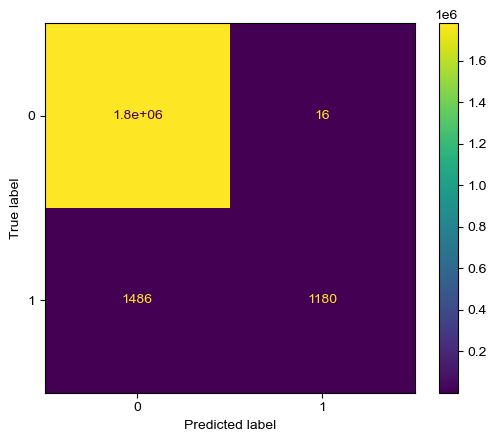

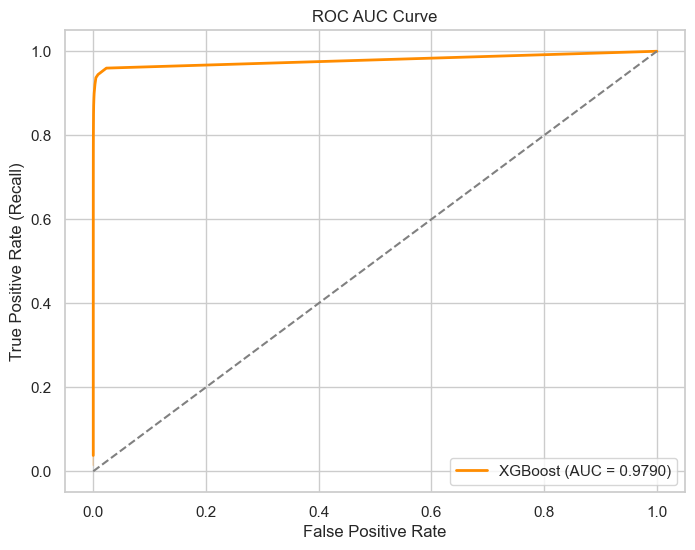

In [170]:
generate_model_report(y_pred, rf_clf)


In [171]:
xgb = XGBClassifier( objective='binary:logistic',
                    eval_metric='auc',
                    scale_pos_weight = (np.sum(y_train == 0) / np.sum(y_train == 1))
                   )

In [172]:
xgb.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [173]:
y_pred = xgb.predict(x_test)


Accuracy:- 0.9864789149480676
Precision:- 0.09430106713085598
Recall:- 0.9347336834208552
F1 Score:- 0.17131857555341676
ROC AUC Score: 0.9606450428498812


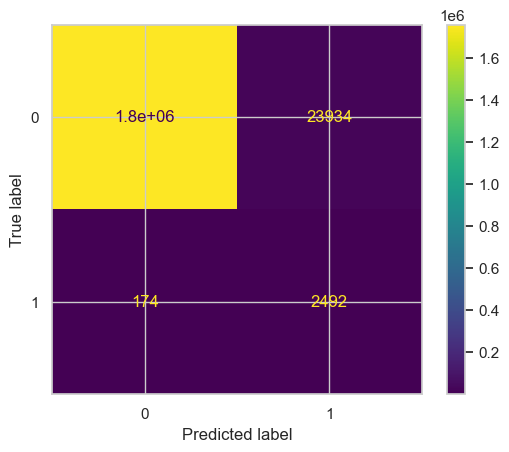

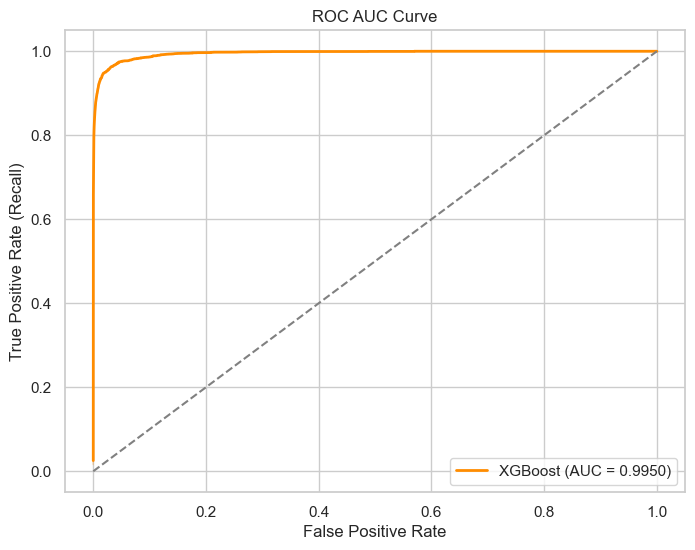

In [174]:
generate_model_report(y_pred, xgb)


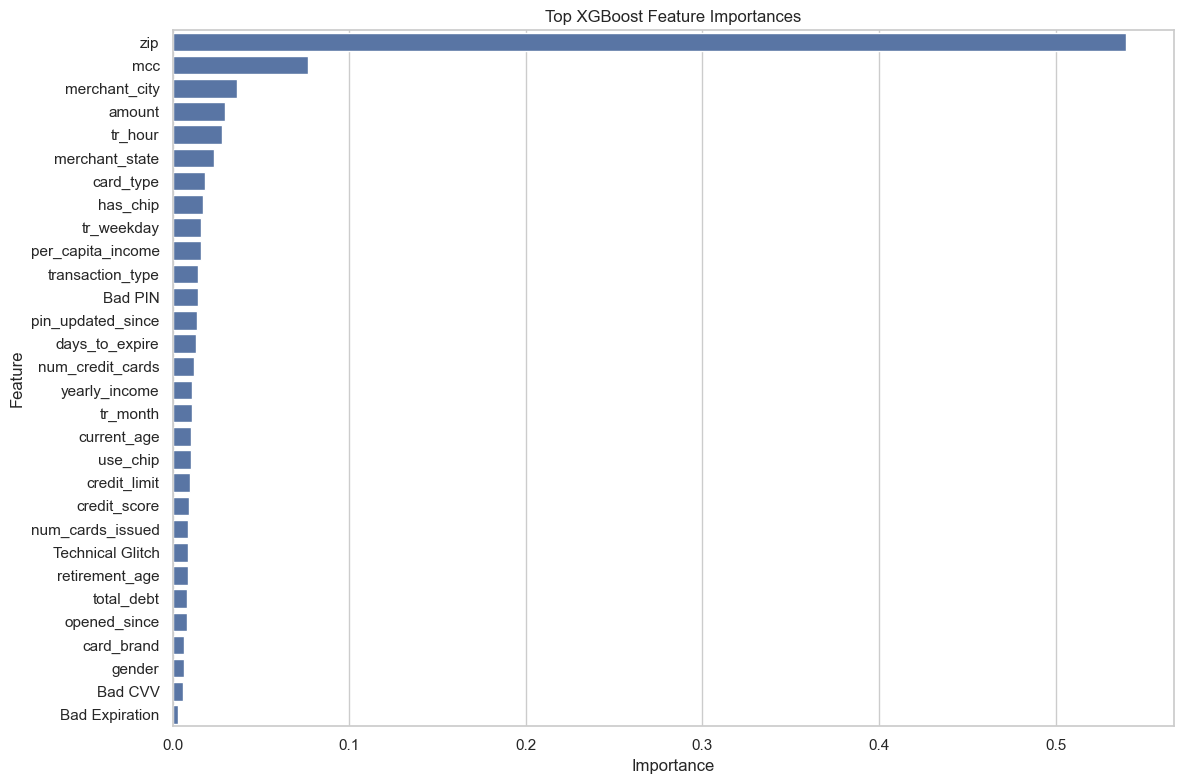

In [175]:
importance = xgb.feature_importances_

feat_imp = pd.DataFrame({
    'Feature': x.columns,
    'Importance': importance
})

feat_imp = feat_imp.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feat_imp.head(30))  # Top 30
plt.title('Top XGBoost Feature Importances')
plt.tight_layout()
plt.show()

In [176]:
reduced_features = feat_imp[feat_imp['Importance'] > 0.01]['Feature'].tolist()

x = x[reduced_features]
x.columns

Index(['zip', 'mcc', 'merchant_city', 'amount', 'tr_hour', 'merchant_state',
       'card_type', 'has_chip', 'tr_weekday', 'per_capita_income',
       'transaction_type', 'Bad PIN', 'pin_updated_since', 'days_to_expire',
       'num_credit_cards', 'yearly_income', 'tr_month', 'current_age',
       'use_chip'],
      dtype='object')

In [177]:
# Splitting the data again after feature reduction
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

In [179]:
from sklearn.preprocessing import LabelEncoder

# Encode 'No'/'Yes' to 0/1
le = LabelEncoder()
y = le.fit_transform(y)   # Now 'No' → 0, 'Yes' → 1

# Proceed with split
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y
)

# Train model
xgb.fit(x_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, ...)

In [180]:
y_pred = xgb.predict(x_test)


Accuracy:- 0.9851906317074717
Precision:- 0.08681727991088523
Recall:- 0.9354838709677419
F1 Score:- 0.15888892428248336
ROC AUC Score: 0.9603744687207426


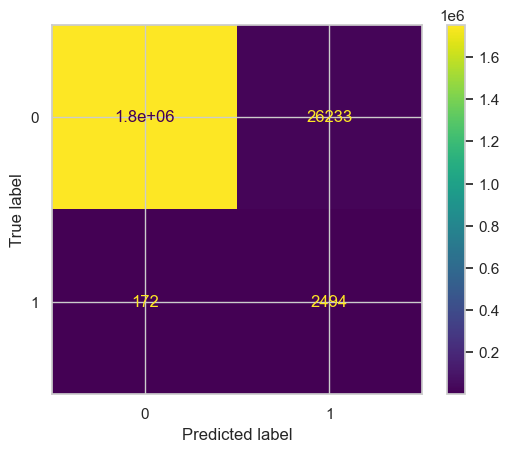

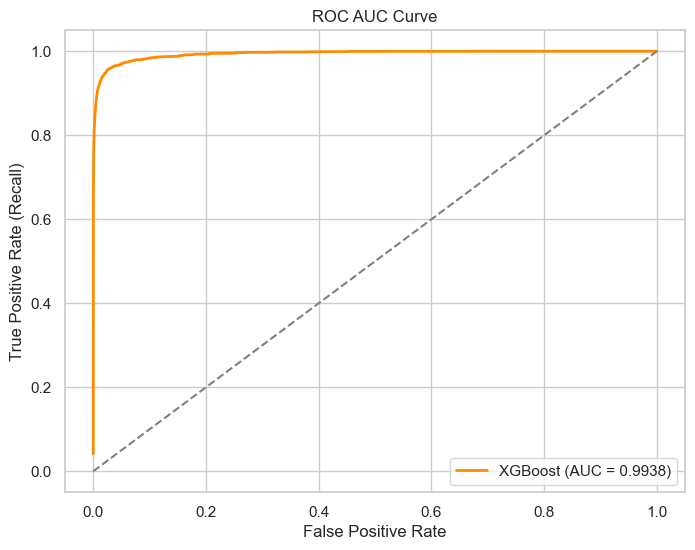

In [181]:
generate_model_report(y_pred, xgb)
